# Simulations modèle ICSV

In [1]:
import vocal_tract_constrained_cpp as vc
from body_vocal_tract import *
from terminal_impedance import *

import pyphs as phs
import sympy as sy
import numpy as np
import os
#from utils import signal_generator
#from utils import functions
#from utils.glottal_signal_generator import glottal_signal
#from utils.signal_generator import simple_mouth_opening
#from utils.signal_generator import mouth_opening_and_glottal
#from utils.timer import Timer as Timer
import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavWrite
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

import pdb

In [2]:
import time
import datetime
class Timer(object):
    """ 
    Allows one to time a particular set of actions.
    
    Example:
    ```(Python)
        with Timer('foo_stuff'):
           # do some foo
           # do some stuff
    ```
    
    Credit: Eli Bendersky
    https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
    """
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()
        currentDT = datetime.datetime.now()
        print('Start: ' + str(currentDT))

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: {:4.2f} sec'.format(time.time() - self.tstart))

In [3]:
phs.__version__
IMPULSE_RESPONSE = True

## Instanciation de l'objet `core`
On considère que la largeur $L$ est égale à la hauteur au repos $h_0$ pour un tronçon donné.

Pour la voyelle A, on prend $A_1 = \frac{1}{10} A_2$ avec $A_i$ l'aire de la section du tronçon $i=1,2$.

In [4]:
from importlib import reload  
reload(vc)

N_tube       = 6
label        = 'vocal_tract'
forme_model  = 'quad_comp_shift'
total_length = 0.175

h = 0.02 
L = h


h_ray = 0.08
Sray = (h_ray)**2

VT_subs = {
        'P_0'       : 101.325e03,
        'rho_0'     : 1.225,
        'gamma'     : 1.4,
        'Z_ray'     : 128/(9*Sray),
        }

# Calcul des V0
for i in range(N_tube): # V = 2 * ell * L * h
    ind = str(i+1)
    VT_subs["ell_" + ind] = total_length/(2*N_tube)
    VT_subs["L_" + ind]   = L
    Sw                    = 2*VT_subs['ell_' + ind]*L
    VT_subs["V_0_" + ind] = Sw*h

# Assemblage des dictionnaires
VT_subs_tot = dict(VT_subs)

core = vc.VocalTractLumpedParameter(
                                    N     = N_tube,
                                    label = label,
                                    **VT_subs_tot,
                                    )

assert not core.freesymbols(), 'Il manque des valeurs/échelles'

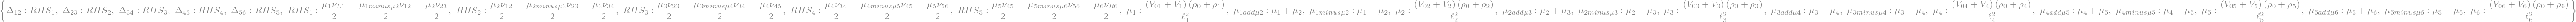

In [5]:
core.observers

In [6]:
# ajout de ressort dans la paroi
body = []
    
for i in range(N_tube):
    body.append(DissipativeSingleSpringBody(n=i+1))
    core = core +  body[i]
    core.add_connector((2, core.y.index(body[i].y[0])), alpha=-1)
    

# ajout d'une impédance de rayonnement
composant_impedance = RadiationImpedance()
core = core + composant_impedance
core.add_connector((1, core.y.index(composant_impedance.y[0])), alpha=1)


core.connect()

In [7]:
## Update subs
body_subs = {}
for i in range(1,N_tube+1):    
    body_subs['k_' + str(i)] = 845
    body_subs['r_' + str(i)] = 0.8

core.subs.update(                                                       
    {core.symbols(k,**PPTY_PHY_PARAMS): v for k, v in body_subs.items()}   
)

## Configuration de la simulation
Initialisation des états/observateurs puis paramètres de la simulation

In [8]:
inits = {'x' : [0.0 for i in range(len(core.x))]}

Calcule des initialisations des observateurs

In [9]:
expr_obs = []
lab_obs = []
subs = {}

# On récupère les observateurs et leurs expressions
for key, val in core.observers.items():
    subs[key] = val.subs(core.subs)
    lab_obs.append(key)
    expr_obs.append(val.subs(subs).subs(core.subs))
    
# On créé les fonctions numpy
f_obs = []
for expr in expr_obs:
    f_obs.append(sy.lambdify(core.x, expr))
    
# On évalue les fonctions
init_obs = []
for func in f_obs:
    init_obs.append(func(*inits['x']))
    
# Formattage numpy
init_obs = np.array(init_obs).T

In [10]:
config = {'fs'   : 1e6, # sample rate (Hz)
          'path' : os.path.join(os.getcwd(), '03_data'), # folder for output results/build
          'lang' : 'c++',
          'cmake': r'cmake',
          'grad' : 'discret',
          'maxit': 20,
          'pbar' : False,
          'split': False,
          'timer': True,
          'epsdg': np.power(np.finfo(np.float64).eps, 0.5),
          'eps'  : np.finfo(np.float64).eps,
         }
print(np.finfo(np.float64).eps)


with Timer('Building method'):
    simu = core.to_simulation(
                              config, 
                              erase = True,
                              inits = inits
                             )

2.220446049250313e-16
Start: 2020-05-13 14:34:55.698414
Build method vocal_tract...
    Init Method...
    Build numerical structure...
    Init update actions...
    Init arguments...
        Build x
        Build dx
        Build w
        Build u
        Build p
        Build vnl
        Build o
    Init functions...
        Build Gnl
        Build ud_o
        Build jacGnlnl
        Build dxH
        Build z
        Build y
Prepare method vocal_tract for C++ generation...
    Init value for x
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Init value for dx
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Init value for ud_x
    Init value for o
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Init value for ud_o
[0.0672000000000000, 0.0672000000000000, 0.0672000000000000, 0.067200000000000